In [23]:
import cv2
import pylab as plt
import dask.array as da
from dask import delayed
from tifffile import imread
import numpy as np
from mptracker import MPTracker
from ipywidgets import *
from IPython.display import display
import pylab as plt
from glob import glob
import json
# Load data
files = np.sort(glob('/Users/joao/data/eyecam/*.tif'))
files = ['/Users/joao/Downloads/test4.tif']
# Because the files have different dims.
sample0 = imread(files[0])
sample1 = imread(files[-1])
lazys = []
for fname in files[:-1]:
    lazys.append([fname,sample0.shape])
lazys.append([files[-1],sample1.shape])
# Dask lazy load
dimread = delayed(imread, pure=True)
lazy_values = [[dimread(fname),shap] for fname,shap in lazys]
arrays = [da.from_delayed(lazy_value,
                          dtype='uint8',
                          shape=shape)
          for lazy_value,shape in lazy_values]
stack = da.concatenate(arrays, axis=0)

# Load parameters for the tracker
with open('/Users/joao/lib/mptracker/notebooks/test1.json','r') as f:
    params = json.load(f)
# Initialize tracker
tracker = MPTracker(params)
tracker.apply(sample0[30])
params['crApprox'] = tracker.crApprox
print('Tracker parameters initialized')

def func(data):
    '''This is for a data block (3 dims)'''
    res = np.zeros([len(data),9])
    tracker = MPTracker(params)
    cv2.setNumThreads(1)
    for i,d in enumerate(data):
        _,(crX,cY),(pX,pY),(short_axis,long_axis),(b,a,phi) = tracker.apply(d)
        res[i,:] = np.array([crX,cY,pX,pY,short_axis,long_axis,b,a,phi])
    return res


trackres = stack.map_blocks(func,
                          drop_axis = [1,2],
                          new_axis = [1],
                          chunks=(stack.chunks[0], 9),  
                          dtype=float)
import time
tstart = time.time()
import dask
import dask.multiprocessing
with dask.set_options(get=dask.multiprocessing.get):
    res = trackres.compute()
print('Toke: {0:.1f} sec'.format(time.time()-tstart))

Tracker parameters initialized
Toke: 18.5 sec


/users/joao/local/conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/users/joao/local/conda/envs/py27/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


<IPython.core.display.Javascript object>


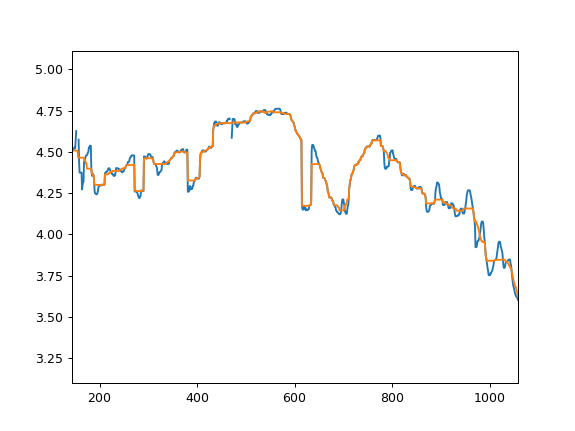

In [24]:
%matplotlib notebook
cleanupidx = np.where(np.abs(np.diff(res[:,4]))>30)[0]
res[cleanupidx,:] = np.nan
from mptracker import computePupilDiameterFromEllipse, computeConversionFactor, convertPixelToEyeCoords
reference = np.array([params['points'][0],params['points'][2]])
diam = computePupilDiameterFromEllipse(res[:,np.array([4,5])],
                                       computeConversionFactor(reference))
az,el,theta = convertPixelToEyeCoords(res[:,np.array([2,3])],
                                      reference,
                                      res[:,np.array([0,1])])
from mptracker import medfilt
plt.plot(diam)
plt.plot(medfilt(diam,31))

plt.show()